In [2]:
import sys
sys.path.append('../')

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np
import utils.paramUtil as paramUtil
from utils.skeleton import Skeleton
from mylib import get_motion, animate3d, get_SMPL_layer, get6d, coco_bone, t2m_bone, smpl_coco_bone, smpl_smpl_bone, smpl_human36_bone, get_neutral_angle_offset, SkeletonWithHead, display_animate2D
from utils.motion_process import recover_from_ric, recover_from_rot, recover_root_rot_pos
from pytorch3d.transforms import quaternion_to_axis_angle, matrix_to_axis_angle, rotation_6d_to_matrix, \
quaternion_to_matrix, axis_angle_to_quaternion, axis_angle_to_matrix, matrix_to_axis_angle, matrix_to_rotation_6d, matrix_to_quaternion
from utils.quaternion import *
import pickle

Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt


In [3]:
coco_head_bone_vis = [(15,22),(22,24),(24,26),(22,23),(23,25)]
smpl_cocohead_bone_vis = t2m_bone + (np.array(coco_head_bone_vis)).tolist()
# coco_head_bone = [(15,22),(15,23),(15,24),(15,25),(15,26)]
# smpl_cocohead_bone = t2m_bone + (np.array(coco_head_bone)).tolist()

In [6]:
smpl_coco_rest_joints.shape

(1, 27, 3)

In [4]:
smpl_data = pickle.load(open('/home/epinyoan/git/smplpytorch/smplpytorch/native/models/basicModel_f_lbs_10_207_0_v1.0.0.pkl', 'rb'), encoding='latin1')
smpl_j_regressor = np.array(smpl_data['J_regressor'].toarray()).astype(np.float32)
coco_head_regressor = np.load('/home/epinyoan/git/Pose2Mesh_RELEASE/data/COCO/J_regressor_coco.npy').astype(np.float32)
coco_head_regressor = coco_head_regressor[:5]

rest_pose = torch.zeros((1,24,3))
verts, rest_joints = get_SMPL_layer(rest_pose.view(1,72), display=False)

coco_head_joints = torch.matmul(torch.from_numpy(coco_head_regressor), verts)
smpl_coco_rest_joints = torch.cat((rest_joints[:,:22], coco_head_joints), axis=1).numpy()

animate3d(smpl_coco_rest_joints, smpl_cocohead_bone_vis)

/home/epinyoan/git/smplpytorch/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


torch.Size([24, 6890])


In [7]:
smpl_cocohead_chain = paramUtil.t2m_kinematic_chain.copy()
smpl_cocohead_chain.append([15,22,24,26])
smpl_cocohead_chain.append([22,23,25])
# 
# for bone in smpl_cocohead_bone_vis:
#     smpl_cocohead_chain.append(bone)

In [8]:
smpl_coco_angle_offset = get_neutral_angle_offset(smpl_cocohead_chain, torch.from_numpy(smpl_coco_rest_joints[0]))
# smpl_angle_offset = get_neutral_angle_offset(paramUtil.t2m_kinematic_chain, rest_joints[0])


In [9]:
data = torch.from_numpy(get_motion('a person runs', motion_length=196)).float()
joint_dataset = recover_from_ric(data, joints_num=22).numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
data.shape

torch.Size([196, 263])

In [10]:
def remove_freeze_frames(joint_dataset):
    moving_score = []
    for f in range(1, joint_dataset.shape[0]):
        compared_center = joint_dataset[f] - joint_dataset[f, 0:1]
        compared_center_prev = joint_dataset[f-1] - joint_dataset[f-1, 0:1]
        m = compared_center - compared_center_prev
        moving_score.append(m.max())
    moving_score = np.array(moving_score)
    np.argmax(moving_score>5e-3)
    s = np.flatnonzero(moving_score>5e-3)
    if len(s) == 0:
        return joint_dataset
    print(s[0],s[-1])
    return joint_dataset[s[0]:s[-1]+2] # +2 b/c 1. step from F=>T and 2. [a:b+1]
joint_dataset = remove_freeze_frames(joint_dataset)

77 194


In [11]:
joint_dataset.shape

(119, 22, 3)

In [12]:
head_diff = joint_dataset[:1,15:16] - smpl_coco_rest_joints[:1, 15:16]
joint_bone_offset_with_head = np.concatenate((joint_dataset[:1], smpl_coco_rest_joints[:,22:27] + head_diff), axis=1)
animate3d(joint_bone_offset_with_head, smpl_cocohead_bone_vis)

### Angle.
- Using angle (directly from the MotionDiffuse), the center joints rotation is wrong, not sure why
### Plugin Head using IK


In [13]:
head_quat = np.zeros((joint_dataset.shape[0],5,3))
joint_with_head = np.concatenate((joint_dataset, head_quat), axis=1)

# 1. get body quatanion
tgt_skel = SkeletonWithHead(smpl_coco_angle_offset, smpl_cocohead_chain, 'cpu')
quat_params = tgt_skel.inverse_kinematics_np(joint_with_head, face_joint_idx=[2, 1, 17, 16], head_chain=smpl_cocohead_chain[5:])

# 2.1 IK
smpl_coco_quat = torch.from_numpy(quat_params).float()

# 2.2 FK
tgt_offsets = tgt_skel.get_offsets_joints(torch.from_numpy(joint_bone_offset_with_head[0]))
joint_forward = tgt_skel.forward_kinematics(smpl_coco_quat, root_pos=torch.from_numpy(joint_dataset[:,0]))

smpl_smplcoco_bone = t2m_bone + (np.array(smpl_cocohead_bone_vis)+22).tolist()
joint_original_smplcoco = np.concatenate((joint_dataset[:,:22], joint_forward.cpu().numpy()), axis=1)
animate3d(joint_original_smplcoco, smpl_smplcoco_bone, first_total_standard=63)

### Select only COCO joints

In [11]:
# 22 nose      0
# 24 left eye  1
# 23 right eye 2
# 26 left ear  3
# 25 right ear 4

# 17 "lshoulder", # 5
# 16 "rshoulder", # 6
# 19 "lelbow",    # 7
# 18 "relbow",    # 8
# 21 "lwrist",    # 9
# 20 "rwrist",    # 10
# 2 "lhip",      # 11
# 1 "rhip",      # 12
# 5 "lknee",     # 13
# 4 "rknee",     # 14
# 8 "lankle",    # 15
# 7 "rankle",    # 16

coco_id = [22,24,23,26,25,17,16,19,18,21,20,2,1,5,4,8,7]
coco_data = joint_forward[:, coco_id].numpy()
animate3d(coco_data, coco_bone)

### Camera Rotation
[Rotation Matrix](https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d)
[Change Basis](https://en.wikipedia.org/wiki/Change_of_basis#:~:text=is%20the%20change%2Dof%2Dbasis,for%20infinite%2Ddimensional%20vector%20spaces.)
### Weak Perspective
https://datahacker.rs/camera-calibration-weak-perspective/

### 2D Prjection

In [12]:
#    ^
#    |
# camera 0' angle
# <--- camera 90' angle
def rotate_data(data, angle):
    theta = angle/180*np.pi
    basis = np.array([0,1])
    rotate_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    new_data = np.dot(data, rotate_matrix)
    return new_data
rotate_data(np.array([[[1,1]], [[0,2]]]), 45)

array([[[1.41421356e+00, 1.11022302e-16]],

       [[1.41421356e+00, 1.41421356e+00]]])

In [13]:
def addjust_center(data, torso_size=40):
    # calculate torso
    neck = (data[:, 5, :2] + data[:, 6, :2])/2
    center_hip = (data[:, 11, :2] + data[:, 12, :2])/2
    h = np.linalg.norm(neck-center_hip, axis=1)
    
    # move to (0,0) mean
    center_x = center_hip[:, 0].mean()
    center_y = center_hip[:, 1].mean()
    data[:, :, 0] = data[:, :, 0] - center_x
    data[:, :, 1] = data[:, :, 1] - center_y
    
    # scale by torso
    data[:, :, :2] = data[:, :, :2] / h.mean() * torso_size  # mean torso = 80
    
    # move to center
    data[:, :, 0] += 320/2
    data[:, :, 1] += 240/2
    return data
    

In [23]:
def convert3D_to_2D(data, angle=90):
    # rotate along x-z plan of MotionDiffuse standard
    temp = rotate_data(data[:, :, [0,2]], angle)
    data[:, :, 0] = temp[:, :, 0]
    data[:, :, 2] = temp[:, :, 1]

    # params
    skyline = data[:, :, 1].mean()
    zoom = 5 # move 'z=0' to zoom point
    torso_size = 20

    # adjust to origin xyz
    data[:, :, 0] -= data[:, :, 0].mean()
    data[:, :, 1] -= skyline
    data[:, :, 1] *= -1 # follow HRNet from GaitGraph data standard
    data[:, :, 2] -= data[:, :, 2].min()
    z_scale = data[:, :, 2] + zoom 

    data[:, :, 0] /= (data[:, :, 2] + z_scale)
    data[:, :, 1] /= (data[:, :, 2] + z_scale)

    data = addjust_center(data, torso_size)[:, :, :2]
    return data

coco_data = joint_forward[:, coco_id].numpy()
coco_data = convert3D_to_2D(coco_data, angle=45)
display_animate2D(coco_data, 320, 240)

<IPython.core.display.Javascript object>

In [21]:
sys.path.append('/home/epinyoan/git/GaitSelfFormer/v2_all/src/datasets')
from augmentation import add_translation_scale_rotate_noise2

# motion diffuse
# _coco_data = np.load('/home/epinyoan/git/MotionDiffuse/text2motion/study/output/19_9_a person crawls.npy')
# _coco_data = convert3D_to_2D(_coco_data, angle=90)
# _coco_data = add_translation_scale_rotate_noise2(_coco_data.copy())

data_paths = np.load('/home/epinyoan/dataset/Human3.6M/2d/extracted/path_names.npy', allow_pickle=True)
_data_paths = []
for data_path in data_paths:
    _data_paths.append(data_path['path'])
data = np.load(_data_paths[800])
def adjust_resolution(data):
    data[:,:,:2] = data[:,:,:2]/4
    data[:,:,0] += 50
#         data[:,:,2] *= 6.192790716581042 # adjust conf threshold
    data[:,:,2] /= .16147809
    return data
data = data[::4]
data = adjust_resolution(data)
_coco_data = data
# _coco_data = add_translation_scale_rotate_noise2(data.copy())

display_animate2D(_coco_data, 320, 240), len(_data_paths)

<IPython.core.display.Javascript object>

(<matplotlib.animation.FuncAnimation at 0x7fbc08ea7850>, 1196)

<IPython.core.display.Javascript object>


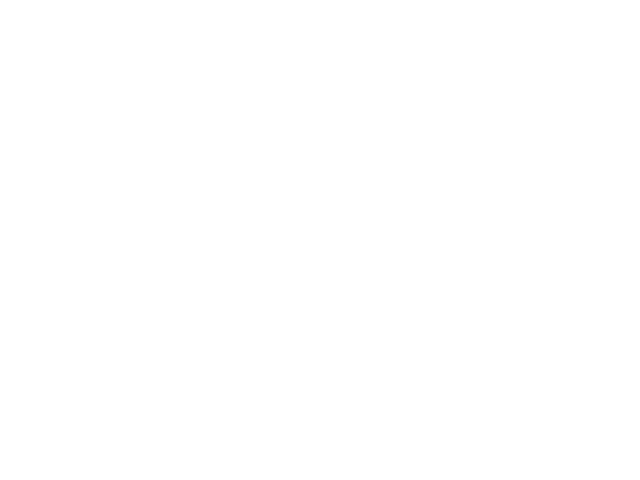

2


<IPython.core.display.Javascript object>

(<matplotlib.animation.FuncAnimation at 0x7fbc442c5330>, 95000)

In [22]:
import glob
from torch.utils.data import Dataset
import random

class MotionDiffuseCOCO(Dataset):
    def __init__(
        self,
        transform=None,
    ):
        self.data_paths = sorted(glob.glob('/home/epinyoan/git/MotionDiffuse/text2motion/study/output/*'))
        self.transform = transform
        
    def __len__(self):
        return len(self.data_paths)*100
    
    def __getitem__(self, index):
        index = index%len(self.data_paths)
        data = np.load(self.data_paths[index])
        skip_frame = random.randint(1,2)
        print(skip_frame)
        data = data[::skip_frame]
        data = convert3D_to_2D(data, angle=random.randint(0,360))
        
        if self.transform is not None:
            data = self.transform(data)
        return data

dataset = MotionDiffuseCOCO()
plt.cla()
display_animate2D(dataset[0], 320, 240), len(dataset)